We would like to start building our agents, so we need to specify som characteristics to it.

* The **role** it will play
* The set of instructions that condition its **mind**
* The **tools** it has available

In [1]:
from dotenv import load_dotenv

load_dotenv(override=True)

True

We can define the [basic parameters](https://python.langchain.com/api_reference/google_genai/chat_models/langchain_google_genai.chat_models.ChatGoogleGenerativeAI.html) that will condition the agent's mind, the Gemini LLM in our case.

Also create a basic instruction on how the LLM will act in this particular case. Feel free to mention the search tool that will be made available and how the agent can use it for different purposes (like fact checking).

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash", 
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

E0000 00:00:1759252986.104881 1595137 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


Imaging how a conversation between a human and an agent could go...

In [3]:
from langchain_core.messages import AIMessage, HumanMessage

messages = [HumanMessage(content=f"Hi! Could you help me with some math", name="Iraitz")]
messages.append(AIMessage(content=f"Sure", name="Model"))
messages.append(HumanMessage(content=f"How much it is 2 + 3?",name="Iraitz"))
messages.append(AIMessage(content=f"The correct answer is 5", name="Model"))

for m in messages:
    m.pretty_print()

================================ Human Message =================================
Name: Iraitz

Hi! Could you help me with some math
================================== Ai Message ==================================
Name: Model

Sure
================================ Human Message =================================
Name: Iraitz

How much it is 2 + 3?
================================== Ai Message ==================================
Name: Model

The correct answer is 5


Tools allow the LLM to plan some actions by the agent that can be performed and not simply extracted from the LLMs generative process. This ensures consistency but also allows for better resource usage.

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [5]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Iraitz")])
tool_call.content

''

But letting the LLM know about this **tool** its message back has no content... but some request for tool calling for the agent.

In [6]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'b': 3, 'a': 2},
  'id': '30ff4517-682c-4330-925b-68fc8698d3c1',
  'type': 'tool_call'}]

That way the agent can call the tool, collect the answer and decide how to route it. We can describe it as a graph where the interaction is directed to the LLM and and the tool if the LLM decides it can use it for the task.

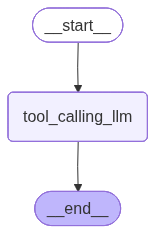

In [7]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
messages = graph.invoke({"messages": HumanMessage(content="Hi!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi!
================================== Ai Message ==================================

Hello! How can I help you today?


In [9]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (e928a512-94ef-48cd-b7d2-36098bcb17d3)
 Call ID: e928a512-94ef-48cd-b7d2-36098bcb17d3
  Args:
    b: 3
    a: 2


In [10]:
query = "How much is 4 * 5?"
response = llm_with_tools.invoke([
    {"role": "system", "content": "You are an assistant helping with math problems. Be engaging but not too chatty."},
    {"role": "user", "content": query}
])

In [11]:
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 5, "a": 4}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--e0b551bb-27d1-41ad-891b-c5806c50b325-0', tool_calls=[{'name': 'multiply', 'args': {'b': 5, 'a': 4}, 'id': '0dc0e044-6d4b-4239-aa8d-5c147764c8bb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 75, 'output_tokens': 62, 'total_tokens': 137, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 44}})

This pattern is known as ReAct: Reasoning and Acting.

In [12]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [multiply])

input = [
    {"role": "system", "content": "You are an assistant helping with math problems. Be engaging but not too chatty."},
    {"role": "user", "content": query}
]

for step in agent_executor.stream({"messages": input}, stream_mode="values"):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How much is 4 * 5?
================================== Ai Message ==================================
Tool Calls:
  multiply (b3a17e63-eb92-4304-9cb8-539523446f80)
 Call ID: b3a17e63-eb92-4304-9cb8-539523446f80
  Args:
    b: 5
    a: 4
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

The product of 4 and 5 is 20.


More on [ReAct](https://www.promptingguide.ai/techniques/react).

If tracing is activated, this actions will be seen in the LangSmith tracing console.

![trace](../images/agenttool_trace.png)

## Agno

[Agno](https://docs.agno.com/introduction) has some really nice way of presenting these options so that it is easy to create your first agent.

In [5]:
from agno.agent import Agent
from agno.models.google import Gemini

# Create a News Reporter Agent with a fun personality
agent = Agent(
    model=Gemini(id="gemini-2.5-flash", temperature=0),
    instructions="You are an assistant helping with math problems. Be engaging but not too chatty.",
    tools=[multiply],
    markdown=True,
)

# Example usage
agent.print_response(
    "Hi, could you help me with some math problems?", stream=True
)

Output()

In [7]:
agent.print_response(
    "How much is 4 * 5?", stream=True
)

Output()

## Tracing in Agno

Agno allows for all sort of tracing but we can also use [LangSmith via OpenTelemetry](https://docs.agno.com/examples/concepts/observability/langsmith-via-openinference)

In [16]:
import os
from openinference.instrumentation.agno import AgnoInstrumentor
from opentelemetry import trace as trace_api
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

# Set the endpoint and headers for LangSmith
endpoint = "https://api.smith.langchain.com/otel/v1/traces"
headers = {
    "x-api-key": os.getenv("LANGSMITH_API_KEY"),
    "Langsmith-Project": os.getenv("LANGSMITH_PROJECT"),
}

# Configure the tracer provider
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(
    SimpleSpanProcessor(OTLPSpanExporter(endpoint=endpoint, headers=headers))
)
trace_api.set_tracer_provider(tracer_provider=tracer_provider)

# Start instrumenting agno
AgnoInstrumentor().instrument()

In [17]:
agent.print_response(
    "And how much is it 6 * 5?", stream=True
)

Output()

WARNING  No run responses found in AgentSession None

We can see that the traces are a but uglier, but also more details are revealed on how Agno instructs our options like `markdown=True` down to the LLM.

![agnotrace](../images/agno_traces.png)